In [1]:
import dataset
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
label_ls = ['Banana', 'Apple', 'Strawberry', 'Pineapple', 'Orange']

In [3]:
def PIL2Tensor(path,label,label_list):
    
    """
    This function takes in two String args
    path : Absolute path to the image from dataframe
    label : Corresponding Label to the image
     Returns:
     Image and Label as Variable 
    """
    image = Image.open(path)
    image = transforms.ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
    #image = Variable(image)
    for i , x in enumerate(label_list):
        if label == x:
            break
    return image , torch.tensor([i])

In [4]:
df = dataset.create_and_load_meta_csv_df("Data",split=0.8)

In [5]:
class ImageLoad(Dataset):
    """ Fruit dataset """
    
    

    # Initialize your data, download, etc.
    def __init__(self,df):
        
        label = ['Banana', 'Apple', 'Strawberry', 'Pineapple', 'Orange'] #df.iloc[:,1].unique()
        self.len = len(df.index)
        self.x_data , self.y_data = PIL2Tensor(df.iloc[0,0],df.iloc[0,1],label)
        
        for co in range(self.len):
            
            temp_data , temp_label = PIL2Tensor(df.iloc[co,0],df.iloc[co,1],label)
            self.x_data = torch.cat((self.x_data,temp_data))
            self.y_data = torch.cat((self.y_data,temp_label))

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [6]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(9680, 5)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x)
        return F.log_softmax(x)


In [7]:
dataset = ImageLoad(df[1])
train_loader = DataLoader(dataset=dataset,
                          batch_size=32,
                          shuffle=True)
dataset_train = ImageLoad(df[2])
test_loader = DataLoader(dataset=dataset_train,
                          batch_size=32,
                          shuffle=True)


In [8]:
model = Net()

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


In [10]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


In [11]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
for epoch in range(1, 5):
    train(epoch)
    test()

/home/sameer/anaconda3/envs/HC#4705_stage1/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/sameer/anaconda3/envs/HC#4705_stage1/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


Train Epoch: 1 [0/1954 (0%)]	Loss: 1.598716
Train Epoch: 1 [320/1954 (16%)]	Loss: 1.510603
Train Epoch: 1 [640/1954 (32%)]	Loss: 0.925762
Train Epoch: 1 [960/1954 (48%)]	Loss: 0.615894
Train Epoch: 1 [1280/1954 (65%)]	Loss: 0.151429
Train Epoch: 1 [1600/1954 (81%)]	Loss: 0.694701
Train Epoch: 1 [1920/1954 (97%)]	Loss: 0.077839


/home/sameer/anaconda3/envs/HC#4705_stage1/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/home/sameer/anaconda3/envs/HC#4705_stage1/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/sameer/anaconda3/envs/HC#4705_stage1/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':



Test set: Average loss: 1.0865, Accuracy: 358/489 (73%)

Train Epoch: 2 [0/1954 (0%)]	Loss: 0.907558
Train Epoch: 2 [320/1954 (16%)]	Loss: 0.040669
Train Epoch: 2 [640/1954 (32%)]	Loss: 0.019708
Train Epoch: 2 [960/1954 (48%)]	Loss: 0.032243
Train Epoch: 2 [1280/1954 (65%)]	Loss: 0.025043
Train Epoch: 2 [1600/1954 (81%)]	Loss: 0.014207
Train Epoch: 2 [1920/1954 (97%)]	Loss: 0.008167

Test set: Average loss: 0.0206, Accuracy: 486/489 (99%)

Train Epoch: 3 [0/1954 (0%)]	Loss: 0.035760
Train Epoch: 3 [320/1954 (16%)]	Loss: 0.112360
Train Epoch: 3 [640/1954 (32%)]	Loss: 0.005757
Train Epoch: 3 [960/1954 (48%)]	Loss: 0.008149
Train Epoch: 3 [1280/1954 (65%)]	Loss: 0.009434
Train Epoch: 3 [1600/1954 (81%)]	Loss: 0.023403
Train Epoch: 3 [1920/1954 (97%)]	Loss: 0.005780

Test set: Average loss: 0.0082, Accuracy: 489/489 (100%)

Train Epoch: 4 [0/1954 (0%)]	Loss: 0.007484
Train Epoch: 4 [320/1954 (16%)]	Loss: 0.002090
Train Epoch: 4 [640/1954 (32%)]	Loss: 0.008415
Train Epoch: 4 [960/1954 (48%

In [18]:
def predict(df,i):
    """
    Gives the prediction for ith sample from th Dataframe
    """
    image = Image.open(df.iloc[i,0])
    plt.imshow(image)
    lab_name = df.iloc[i,1]
    plt.title(lab_name)
    image = transforms.ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension
    pred_lab = model(Variable(image))
    for x , y in enumerate(label_ls):
        if y ==lab_name:
            break
    print(torch.argmax(pred_lab[0,:]),x)
    print(label_ls)
    return None

tensor(4) 4
['Banana', 'Apple', 'Strawberry', 'Pineapple', 'Orange']


/home/sameer/anaconda3/envs/HC#4705_stage1/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


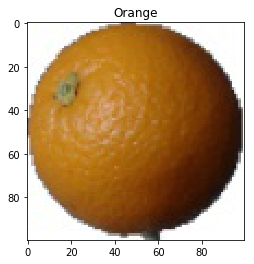

In [23]:
predict(df[0],90)